노래의 특징(댄스 가능성, 라이브성, 음량, 에너지)을 바탕으로 노래가 히트할지 안할지 예측한다

- 데이터 전처리, 머신러닝(모델 선택), 시각화
- 회귀 : 수치 예측
- 앙상블 : 여러 모델들을 혼합해 사용
- GridSearch : 하이퍼파라미터 자동 최적화

데이터셋
Kaggle 데이터셋 : https://www.kaggle.com/datasets/yasserh/song-popularity-

진행목차
1. 데이터 불러오기
2. 데이터 분석(EDA)
3. 데이터 전처리
4. 인기 예측 회귀모델
5. 성능 분석
6. 회귀 모델 고도화

In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl        # 시각화도구(시각화옵션, 폰트설정)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

In [28]:
# 노래 데이터 가져오기
df = pd.read_csv("data/song_data.csv",encoding='utf-8')

target = 'song_popularity' # 타겟 변수 (노래 인기도)

### 타겟 (종속 변수)
- song_popularity : 인기점수 (0점~100점)

### 특징(독립 변수_)
|특성명|설명|범위/값|
|----|----|-------|
| song_name|트랙제목|
| song_duration_ms|  노래길이 |(밀리초 단위)
| acousticness|  어쿠스틱 노래 가능성 |(0~1)
| song_name|  트랙 제목
| danceability|  노래에 춤추기 적합한 정도 |(0~0.99)
| energy|  노래의 에너지 강도 |(0~1.0)
| instrumentalness|  노래에 보컬이 없을 가능성|(0~1.0)
| key|  음악 키|(0 = C, 11 = B, 0~11)
| liveness|  라이브 관객의 존재 추정|(0.01~0.99)
| loudness|  음량 레벨 |( -38.8~1.58)
| audio_mode|  조성|(1:장조, 0:단조)
| speechiness|  발화된 단어가 존재할 가능성|(0.0~0.94)
| tempo|  분당 박자|(BPM)
| time_signature|  음악 한 마디의 박자 |(0~5)
| audio_valance|  트랙의 긍정성 또는 쾌활함 |( 0.0~0.98)

In [29]:
df.drop(["song_name"],axis=1, inplace=True)     # song_name 열은 사용하지 않아 삭제

In [30]:
feature = [i for i in df.columns if i not in [target]]  # 특성 피터링
original_df = df.copy(deep=True)    # 데이터 원본 보존 깊은 복사

print(df.shape)
print(f"이 데이터셋에는 {df.shape[1]}개의 특성과 {df.shape[0]}의 샘플로 구성되어 있다.")

(18835, 14)
이 데이터셋에는 14개의 특성과 18835의 샘플로 구성되어 있다.


# 탐색적 데이터 분석(EDA)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [32]:
# 숫자형, 범주형 특징 식별
nu = df[feature].nunique().sort_values()    # 각 특성별로 고유값(카테고리) 갯수 계산 후 정렬
nf = [] # 숫자형 특성 리스트
cf = [] # 범주형 특성 리스트
nnf = 0 # 숫자형 특성 갯수
ncf = 0 # 범주형 특성 갯수

# nu

# 16개 미만의 값을 가진 특징은 범주형으로 간주한다.
for i in range(df[feature].shape[1]):
    if nu.values[i] <= 16:
        cf.append(nu.index[i])
    else :
        nf.append(nu.index[i])
print(f"이 데이터셋은 {len(nf)}개의 숫자형, {len(cf)}개의 범주형 특성을 가지고 있다.")
print(f"범주형 특성: {cf}")
print(f"숫자형 특성: {nf}")

이 데이터셋은 10개의 숫자형, 3개의 범주형 특성을 가지고 있다.
범주형 특성: ['audio_mode', 'time_signature', 'key']
숫자형 특성: ['danceability', 'energy', 'speechiness', 'audio_valence', 'liveness', 'acousticness', 'instrumentalness', 'loudness', 'song_duration_ms', 'tempo']


In [33]:
df['song_popularity']

0        73
1        66
2        76
3        74
4        56
         ..
18830    60
18831    60
18832    23
18833    55
18834    60
Name: song_popularity, Length: 18835, dtype: int64

In [34]:
df[nf].describe().T # 통계량을 행이 아닌 컬럼별로 한줄씩 보이게 한다.

,count,mean,std,min,25%,50%,75%,max
danceability,18835.0,0.633348,0.156723,0.000000,0.5330,0.645000,0.74800,0.987
energy,18835.0,0.644995,0.214101,0.001070,0.5100,0.674000,0.81500,0.999
speechiness,18835.0,0.102099,0.104378,0.000000,0.0378,0.055500,0.11900,0.941
audio_valence,18835.0,0.527967,0.244632,0.000000,0.3350,0.527000,0.72500,0.984
liveness,18835.0,0.179650,0.143984,0.010900,0.0929,0.122000,0.22100,0.986
acousticness,18835.0,0.258539,0.288719,0.000001,0.0241,0.132000,0.42400,0.996
instrumentalness,18835.0,0.078008,0.221591,0.000000,0.0000,0.000011,0.00257,0.997
loudness,18835.0,-7.447435,3.827831,-38.768000,-9.0440,-6.555000,-4.90800,1.585
song_duration_ms,18835.0,218211.587576,59887.540566,12000.000000,184339.5000,211306.000000,242844.00000,1799346.000
tempo,18835.0,121.073154,28.714456,0.000000,98.3680,120.013000,139.93100,242.318


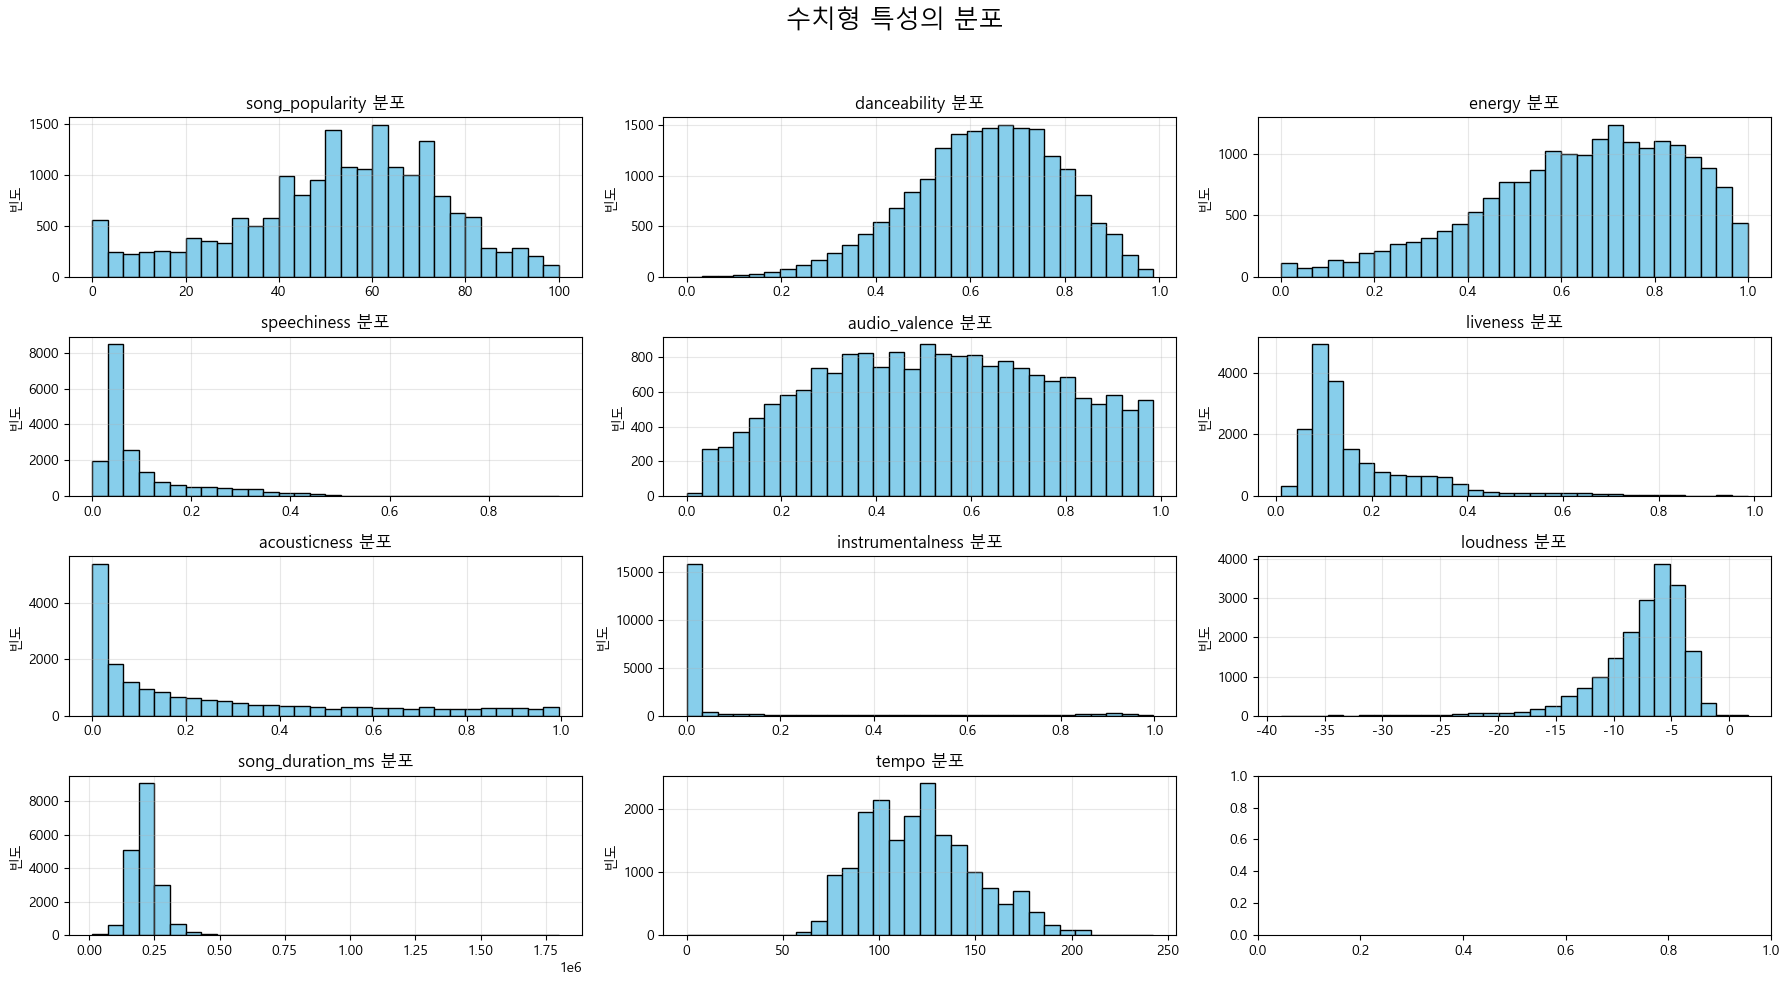

In [39]:
# 수치형 변수의 분포
columns = [target] + nf         # 타겟(인기도)와 숫자형 특성들 리스트

fig, axes = plt.subplots(4, 3, figsize=(18,10))         # 4행 3열의 서브플롯(그래프) 생성

for idx, col in enumerate(columns):
    row = idx // 3              # 몇번째 행에 그릴지 결정
    col_idx = idx % 3           # 몇번째 열에 그릴지 결정
    axes[row][col_idx].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')      # 히스토그램 그리기
    axes[row][col_idx].set_title(f"{col} 분포")
    axes[row][col_idx].set_ylabel('빈도')
    axes[row][col_idx].grid(alpha=0.3)      # 격자(그리드 표시), 투명도 0.3


plt.suptitle("수치형 특성의 분포", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

우측이나 좌측으로 많이 쏠린(왜도)컬럼들은 로그변환들이 필요할 수 있다. 이를 통해 정규 분포(가우시안 분포)에 가깝게 만들 수 있다.pl

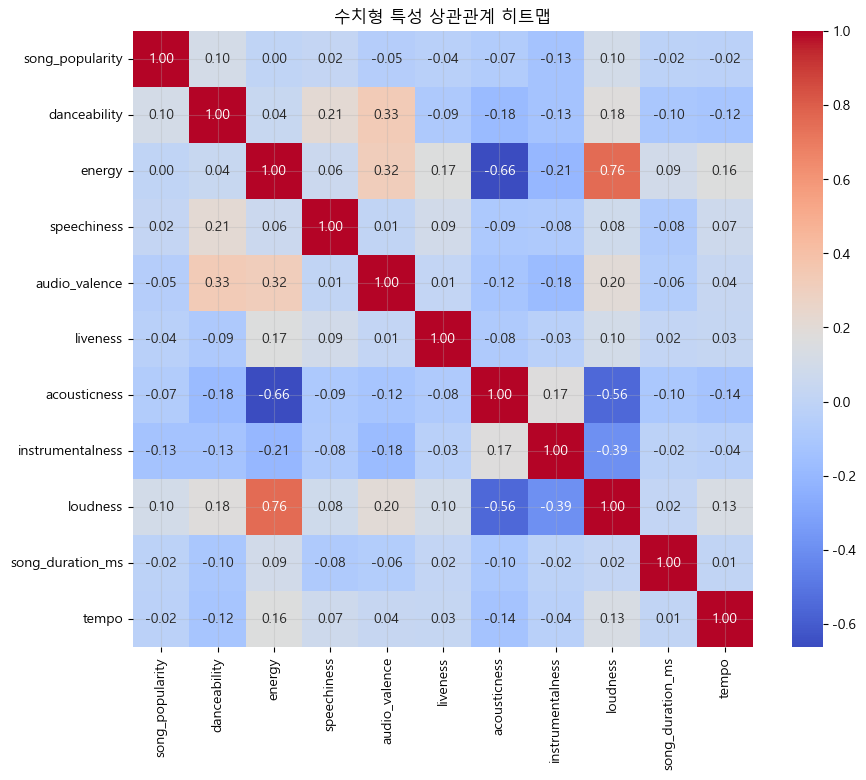

In [41]:
# 수치형 특성간 상관관계 매트릭스
plt.figure(figsize=(10,8))
corr_matrix = df[[target] + nf].corr(numeric_only=True) # 수치형 변수들만 상관관계 개선
sns.heatmap(
    corr_matrix,        # 상관관계 데이터
    annot=True,         # 내부 값 표시
    fmt=".2f",          # 값 형태(소수점 2자리)
    cmap="coolwarm"     # 컬러맵 설정
)   # 히트맵 시각화
plt.title("수치형 특성 상관관계 히트맵")
plt.grid(alpha=0.3) # 투명도 30% 격자
plt.show()

수치형 변수들 확인 결과 목표 변수인 song_popularity와 매우 낮은 상관관계를 보이는 것을 확인.

일부 변수간의 상관관계가 오히려 더 있어보인다. (예: energy - loudness)
=> 다중공선성이 존재할 수 있다.
만약 컬럼간의 중복성이 있다면 하나의 컬럼을 삭제하는것도 고려해봐야 한다.

다중공선성(특정 변수들간의 중복성) 확인하기 위해 VIF(Variance Inflation Facor)를 사용한다.
VIF 5를 초과하면 높은 다중공선성이 있고, 강한 상관관계를 가짐을 의미한다.

In [44]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ------------------------------- -------- 7.6/9.5 MB 47.1 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 31.3 MB/s  0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   

In [42]:
nf

['danceability',
 'energy',
 'speechiness',
 'audio_valence',
 'liveness',
 'acousticness',
 'instrumentalness',
 'loudness',
 'song_duration_ms',
 'tempo']

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant    # 상수항 추가시에 사용

checking_colms = ['instrumentalness','energy','loudness','acousticness','audio_valence']    # VIF 확인할 변수 목록
vif_df = df[checking_colms].copy()
vif_df - vif_df.dropna()

vif_data = add_constant(vif_df) # 상수항(절편) 추가
# vif_data

vif = pd.DataFrame()
vif['feature'] = vif_data.columns
# vif
vif['VIF'] = [variance_inflation_factor(vif.data.values, i) for i in range(shape[1])]   #각 변수별 VIF 계산
vif = vif[vif['feature'] != 'const']    # 상수항 ㅔ죄
vif


NameError: name 'shape' is not defined

1에 가까운 2개의 컬럼은 중복성이 매우 낮다.

그 외 3개의 컬럼은 어느정도 중복성 있어 보인다. 그러나 5를 넘지 않았기 때문에 삭제를 고려할 정도의 수준은 아니다.

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15392\1350290794.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="audio_mode", y="song_popularity", data=df, palette="Set2")


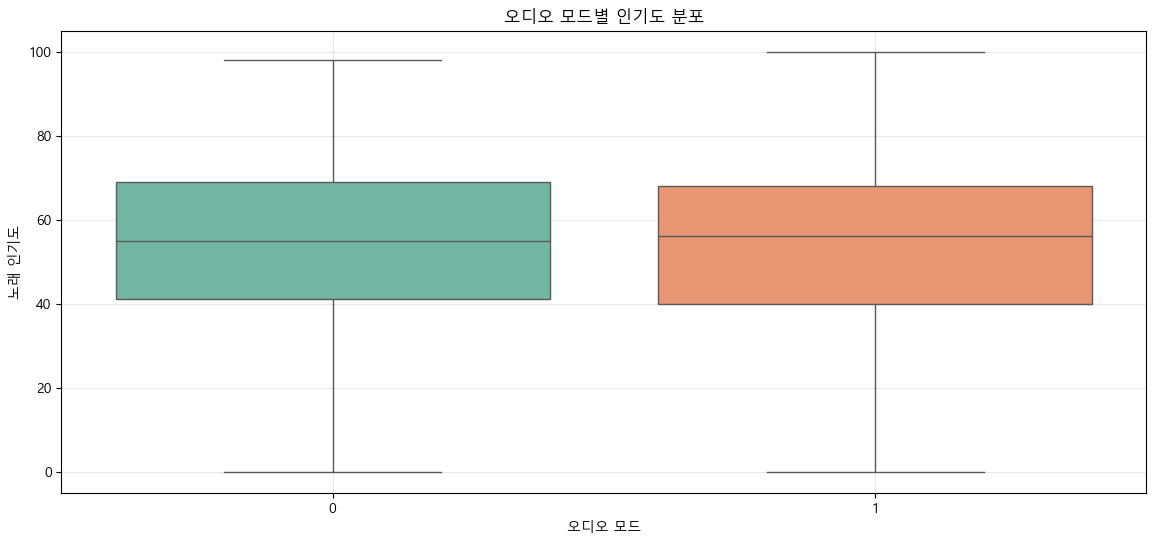

In [49]:
# 범주형 변수의 값에 따른 song_popularity의 관계 확인
plt.figure(figsize=(14, 6))
sns.boxplot(x="audio_mode", y="song_popularity", data=df, palette="Set2")
plt.title("오디오 모드별 인기도 분포")
plt.xlabel("오디오 모드")
plt.ylabel("노래 인기도")
plt.grid(alpha=0.3)
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15392\1371428971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="time_signature", y="song_popularity", data=df, palette="Set2")


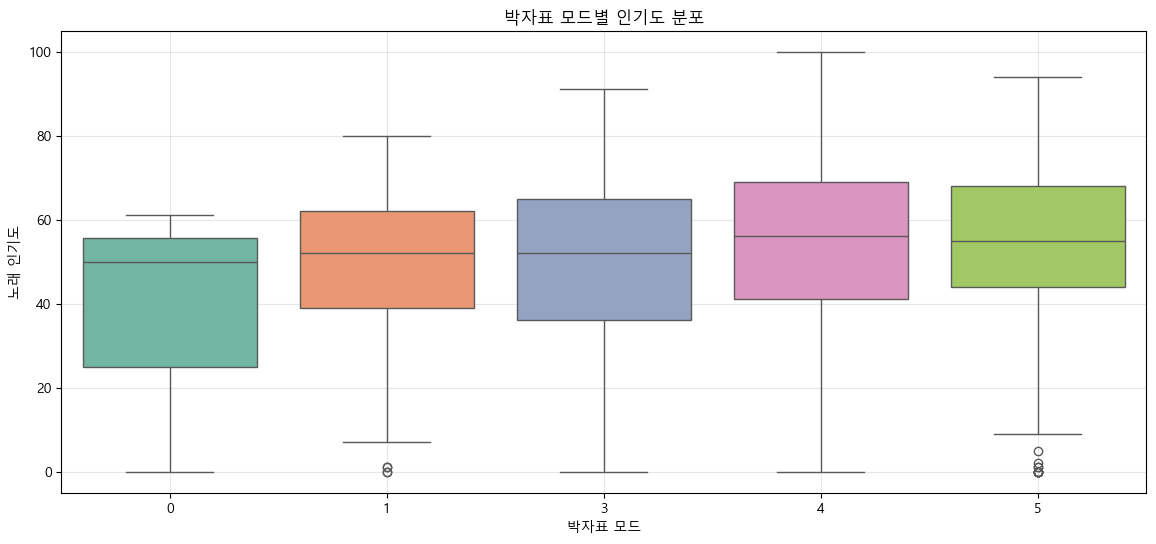

In [50]:
# 범주형 변수의 값에 따른 song_popularity의 관계 확인
plt.figure(figsize=(14, 6))
sns.boxplot(x="time_signature", y="song_popularity", data=df, palette="Set2")
plt.title("박자표 모드별 인기도 분포")
plt.xlabel("박자표 모드")
plt.ylabel("노래 인기도")
plt.grid(alpha=0.3)
plt.show()

범주형 변수들은 개별적으로는 뚜렷한 패턴은 없었다.

### 데이터 전처리
- 결측값 처리 : 결측값은 없었다.
- 이상치 : IQR 방식으로 탐지하여 제거한다.
- 특성 정규화 : 왜도가 있는 수치형 변수(speechiness, liveness, acousticness, instrumentalness)에 대해 정규화 적용해서 정규분포에 가깝게 만들어준다.
- 범주형 변수 인코딩 : 모두 숫자이므로 인코딩 안해도 된다.

In [54]:
# 이상치 데이터 샘플링
df1 = df.copy()

feature1 = nf + ["song_popularity"] # 숫자형 특성과 타겟변수 포함

for i in feature1:
    Q1 = df1[i].quantile(0.25)     # 1사 분위수(25%)
    Q3 = df1[i].quantile(0.75)     # 3사 분위수(75%)
    IQR = Q3 - Q1
    
    df1 = df1[df1[i] <= (Q3 + (1.5 * IQR))] # 이상치 상한성(3사분위수 + 1.5 * IQR) 초과 샘플 제거
    df1 = df1[df1[i] >= (Q1 - (1.5 * IQR))] # 이상치 상한성(1사분위수 + 1.5 * IQR) 미만 샘플 제거
    df1 = df1.reset_index(drop=True)        # 인덱스 재설정
    
print(f"이상치 제거 전 데이터 수 : {df.shape[0]}")
print(f"이상치 제거 전 데이터 수 : {df1.shape[0]}")

df = df1.copy()

이상치 제거 전 데이터 수 : 18835
이상치 제거 전 데이터 수 : 11183


정규화 : 왜도에 있는 컬럼들에 대해 np.lpg1p를 적용한다. => 정규분포를 따르는 가우시안 분포를 그린다

In [57]:
skewed_columns = ['speechiness', 'liveness', 'acousticness', 'instrumentalness']    # 왜도가 확인된 특성 리스트

from copy import deepcopy

df_log = deepcopy(df)   # 원본 데이터 훼손 방지용 복사본 생성
df_log[skewed_columns] = df[skewed_columns].apply(np.log1p) # 해당 컬럼에 log1p(로그 변환) 적용

In [58]:
df_log

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005505,0.496,0.682,0.000029,8,0.057231,-4.095,1,0.028976,167.060,4,0.4740
1,66,216933,0.010247,0.542,0.853,0.000000,3,0.102557,-6.407,0,0.048600,105.256,4,0.3700
2,74,216933,0.026058,0.451,0.970,0.003544,0,0.097127,-4.938,1,0.101654,122.444,4,0.1980
3,56,223826,0.000954,0.447,0.766,0.000000,10,0.107059,-5.065,1,0.030820,172.011,4,0.5740
4,80,235893,0.008910,0.316,0.945,0.000002,4,0.333611,-3.169,0,0.116894,189.931,4,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11178,55,114582,0.640801,0.370,0.136,0.000263,7,0.095219,-13.528,1,0.042389,146.081,4,0.0592
11179,64,216173,0.621651,0.515,0.286,0.000069,5,0.100750,-11.776,1,0.037103,115.076,4,0.2840
11180,62,195106,0.332894,0.644,0.523,0.000000,4,0.088926,-7.660,1,0.037103,95.966,4,0.4450
11181,23,182211,0.613563,0.719,0.325,0.000000,0,0.117783,-12.222,1,0.034884,130.534,4,0.2860


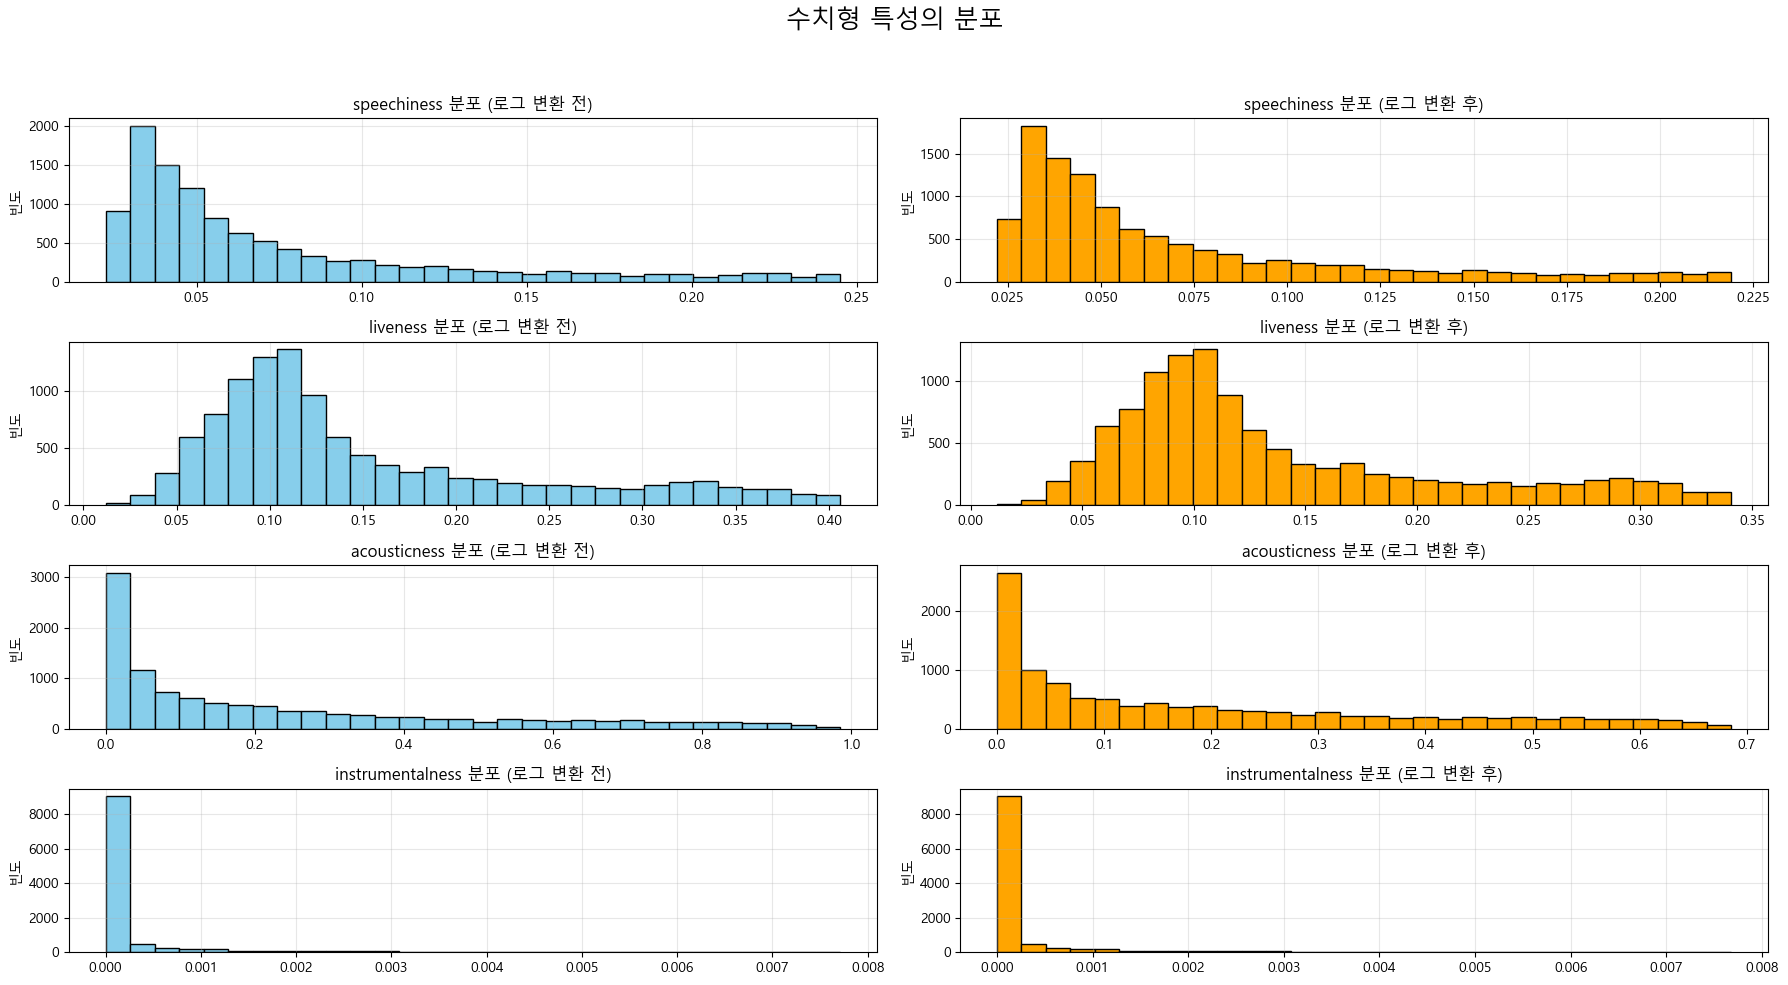

In [64]:
# 보정 전후로 분포 비교
fig, axes = plt.subplots(4, 2, figsize=(18,10))   # 4행(각 컬럼) 2열(전/후) 서브플롯 생성

for idx, col in enumerate(skewed_columns):
    row = idx
    axes[row][0].hist(df[col].dropna(),bins=30,color="skyblue", edgecolor="black")  # 로그 변환전 분포
    axes[row][0].set_title(f"{col} 분포 (로그 변환 전)")
    axes[row][0].set_ylabel("빈도")
    axes[row][0].grid(alpha=0.3)
    
    axes[row][1].hist(df_log[col].dropna(),bins=30,color="orange", edgecolor="black")  # 로그 변환후 분포
    axes[row][1].set_title(f"{col} 분포 (로그 변환 후)")
    axes[row][1].set_ylabel("빈도")
    axes[row][1].grid(alpha=0.3)
    
plt.suptitle("수치형 특성의 분포", fontsize=18)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

log1p 적용 후 분포완화
수치로 변환하여 확인

In [66]:
df[skewed_columns].skew()   # 왜도 값 계산 (0이면 완전 대칭, 0보다 크면 우칙 왜도(양의 왜도)), 0보다 작으면 좌측왜도(음의 왜도)


speechiness         1.552620
liveness            1.156883
acousticness        1.134955
instrumentalness    3.831057
dtype: float64

In [67]:
df_log[skewed_columns].skew() 

speechiness         1.470770
liveness            1.044367
acousticness        0.894389
instrumentalness    3.826448
dtype: float64

In [70]:
df =df_log # 로그 변환된 데이터를 기존 데이터로 사용

df

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005505,0.496,0.682,0.000029,8,0.057231,-4.095,1,0.028976,167.060,4,0.4740
1,66,216933,0.010247,0.542,0.853,0.000000,3,0.102557,-6.407,0,0.048600,105.256,4,0.3700
2,74,216933,0.026058,0.451,0.970,0.003544,0,0.097127,-4.938,1,0.101654,122.444,4,0.1980
3,56,223826,0.000954,0.447,0.766,0.000000,10,0.107059,-5.065,1,0.030820,172.011,4,0.5740
4,80,235893,0.008910,0.316,0.945,0.000002,4,0.333611,-3.169,0,0.116894,189.931,4,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11178,55,114582,0.640801,0.370,0.136,0.000263,7,0.095219,-13.528,1,0.042389,146.081,4,0.0592
11179,64,216173,0.621651,0.515,0.286,0.000069,5,0.100750,-11.776,1,0.037103,115.076,4,0.2840
11180,62,195106,0.332894,0.644,0.523,0.000000,4,0.088926,-7.660,1,0.037103,95.966,4,0.4450
11181,23,182211,0.613563,0.719,0.325,0.000000,0,0.117783,-12.222,1,0.034884,130.534,4,0.2860


### 노래 회귀 예측 모델 구현

In [78]:
# 선형 회귀 모델
from sklearn.linear_model import LinearRegression   # 선형 회귀 모델
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # 회귀 성능 평가 지표
from sklearn.model_selection import train_test_split    # 데이터셋 분할 함수

X = df[feature]    # 입력 변수(특성)
y = df[target]      # 타겟 변수(노래 인기도)

# 학습/테스트 데이터셋 분리(80%:20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train),len(X_test), len(y_train), len(y_test))

8946 2237 8946 2237


In [79]:
# LinearRegression 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)   # 모델 학습

y_pred_lr = lr_model.predict(X_test)    # 테스트셋 예측

# 학습 데이터 평가 (1000개 데이터만 평가)
print("Train MSE:", mean_squared_error(y_train[:1000], lr_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], lr_model.predict(X_train[:1000])))
print("Train R2 스코어:", r2_score(y_train[:1000], lr_model.predict(X_train[:1000])))
print()
# 테스트셋 데이터 평가
print("MSE:",mean_squared_error(y_test,y_pred_lr)) #테스트셋 MSE 
print("MAE:",mean_absolute_error(y_test,y_pred_lr)) #테스트셋 MAE 
print("R2 스코어:",r2_score(y_test,y_pred_lr)) #테스트셋 R2 스코어


Train MSE: 431.63482714669885
Train MAE: 16.57721232458603
Train R2 스코어: 0.06808225594698936

MSE: 439.34301511752426
MAE: 16.695875787455037
R2 스코어: 0.05003437855473547


선형 회귀 모델로는 성능이 매우 뒤떨어짐을 확인하였습니다.

다른 모델을 사용해봐야겠다

In [82]:
# 다항 회귀 모델 : n차 다항식을 사용하여 비선형 관계를 모델하는 모델.
# 단점으로는 모델의 차수가 지나치게 높아지면 모델 복잡성이 커져 과적화 가능성이 있는 모델이다.

from sklearn.preprocessing import PolynomialFeatures

degree = 2  # 다항식 특성의 차수
poly = PolynomialFeatures(degree)           # 특성을 다하익 특성으로 변환
X_train_poly = poly.fit_transform(X_train)  # 학습 데이터 변환
X_test_poly = poly.transform(X_test)        # 테스트 데이터 변환

# 다항식 특성으로 모델 학습
poly_lr_model = LinearRegression()
poly_lr_model.fit(X_train_poly, y_train)

# 예측
y_pred_train = poly_lr_model.predict(X_train_poly) # 학습 셋 예측
y_pred_test = poly_lr_model.predict(X_test_poly) # 태스트셋 예측

# 학습 데이터 평가 (1000개 데이터만 평가)
print("Train MSE:", mean_squared_error(y_train[:1000], y_pred_train[:1000]))
print("Train MAE:", mean_absolute_error(y_train[:1000], y_pred_train[:1000]))
print("Train R2 스코어:", r2_score(y_train[:1000], y_pred_train[:1000]))
print()
# 테스트셋 데이터 평가
print("MSE:",mean_squared_error(y_test,y_pred_test)) #테스트셋 MSE 
print("MAE:",mean_absolute_error(y_test,y_pred_test)) #테스트셋 MAE 
print("R2 스코어:",r2_score(y_test,y_pred_test)) #테스트셋 R2 스코어


Train MSE: 428.2998946533195
Train MAE: 16.495231027466847
Train R2 스코어: 0.07528251544955011

MSE: 432.65386403138456
MAE: 16.56397825866186
R2 스코어: 0.06449793743659493


기존 선형 모델보다는 약간 나아진 모습은 있지만, 성능은 낮다.

In [83]:
# RandomForest 회귀 모델 : 여러개의 의사결정 나무를 결합해 비선형적이고 앙상블 기반의 학습을 제공한다.
# 앙상블 -> 과적합에도 강하다.
from sklearn.ensemble import RandomForestRegressor  # 랜덤 포레스트 회귀 모델

rf_model = RandomForestRegressor(random_state=42)   # 랜덤 포레스트(앙상블) 모델 생성
rf_model.fit(X_train, y_train)  # 학습 데이터로 모델 학습

# 예측
y_pred_rf = rf_model.predict(X_test)    # 테스트 데이터로 예측

# 학습 데이터 평가 (1000개 데이터만 평가)
print("Train MSE:", mean_squared_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train R2 스코어:", r2_score(y_train[:1000], rf_model.predict(X_train[:1000])))
print()
# 테스트셋 데이터 평가
print("MSE:",mean_squared_error(y_test,y_pred_rf)) #테스트셋 MSE 
print("MAE:",mean_absolute_error(y_test,y_pred_rf)) #테스트셋 MAE 
print("R2 스코어:",r2_score(y_test,y_pred_rf)) #테스트셋 R2 스코어

Train MSE: 43.10566981387936
Train MAE: 4.551614510493591
Train R2 스코어: 0.9069330460788059

MSE: 274.77396523761075
MAE: 11.80355589517433
R2 스코어: 0.4058723783873017


전 모델들에 비해서는 향상되었지만 절대적인 성능은 약간 부족하다

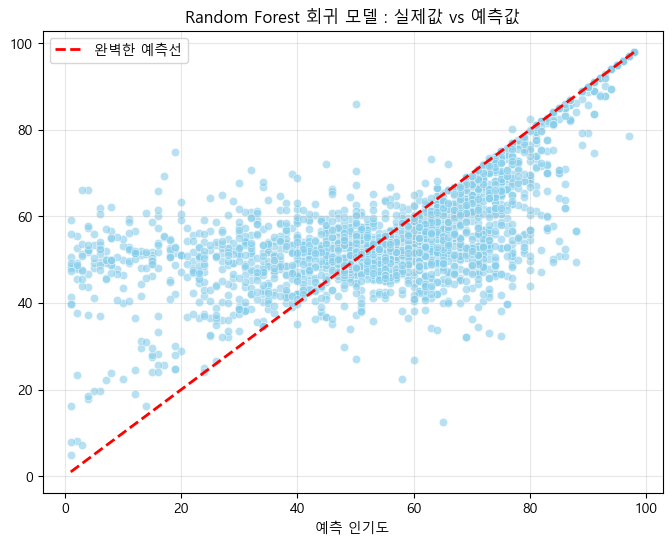

In [84]:
# 성능 시각화 (실제값 vs 예측값)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test , y=y_pred_rf, color='skyblue', alpha=0.6) # 산점도 : 실제값 vs 에측값
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], "r--",linewidth=2, label = "완벽한 예측선") # 대각선(정답선) 표시
plt.xlabel("실제 인기도")
plt.xlabel("예측 인기도")
plt.title("Random Forest 회귀 모델 : 실제값 vs 예측값")
plt.legend()        # 범례
plt.grid(alpha=0.3) # 격자
plt.show()

인기도가 원래 있던 곡들은 그나마 맞추는 편, 인기도가 실제 없었던 곡들은 못맞추는 경향을 보인다.

In [86]:
# Random Forest 모델이 예측할때 중요도 분석
importance = rf_model.feature_importances_  # 각 특성의 중요도 추출
features = X.columns    # 특성명 리스트

feat_df = pd.DataFrame({"특성":features,"중요도":importance})   # 데이터프레임 생성
feat_df.sort_values(by="중요도",ascending=False, inplace=True)  # 중요도 기준 내림차순 정렬
feat_df

,특성,중요도
7,loudness,0.111606
12,audio_valence,0.106750
2,danceability,0.099819
1,acousticness,0.099417
3,energy,0.098184
6,liveness,0.095433
0,song_duration_ms,0.093416
10,tempo,0.090495
9,speechiness,0.087211
4,instrumentalness,0.060503


C:\Users\Playdata\AppData\Local\Temp\ipykernel_15392\2966216977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="중요도" , y="특성", data=feat_df.head(10), palette='viridis') # 상위 10개 특성 중요도 bar플록


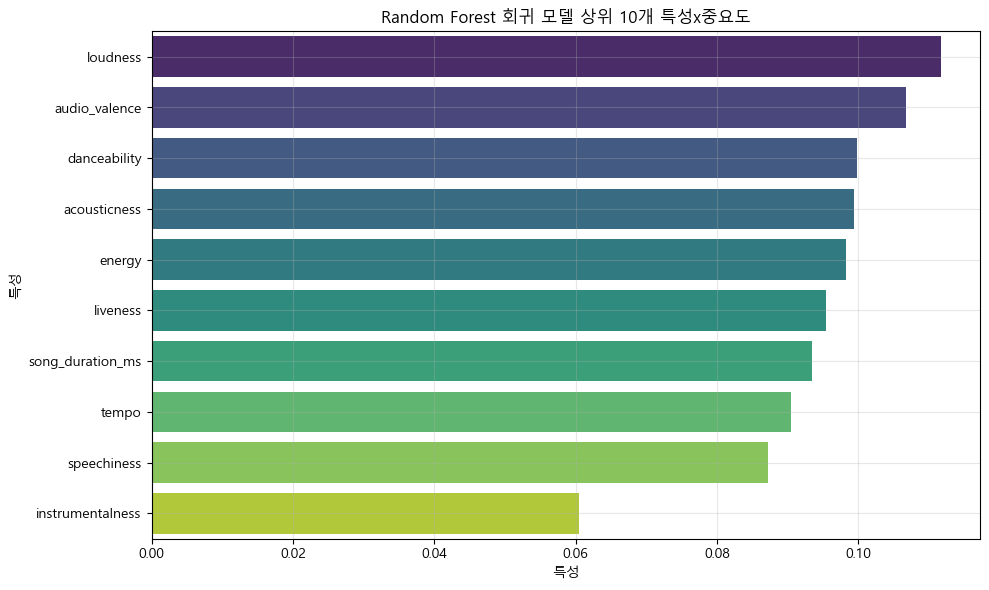

In [87]:
# 시각화
plt.figure(figsize=(10,6))
sns.barplot(x="중요도" , y="특성", data=feat_df.head(10), palette='viridis') # 상위 10개 특성 중요도 bar플록
plt.xlabel("중요도")
plt.xlabel("특성")
plt.title("Random Forest 회귀 모델 상위 10개 특성x중요도")
plt.grid(alpha=0.3) # 격자
plt.tight_layout()
plt.show()

1 상위 3개를 확인했을 때 특성의 중요도가 0.1 정도로 매우 낮다.
2 => 인기도는 특성만으로 뽑기가 좀 애매한 면이 있어 주관적인 사항도 같이 특성으로 반영을 해주면 더 좋은 결과를 얻을수도 있다.

### 회귀 모델 고도화
GridSearchCV를 사용해서 Random Forest모델을 고도화 하려고 한다.
- n_estimators : 숲을 구성할 트리의 갯수 (기본값 100)
- max_depth : 각 트리의 최대 깊이 (기본값 None, 모든 리프 노드가 가장 순수해질 때까지 나무 성장)
- min_samples_split : 내부 노드가 분할하기 위해 필요한 최소 샘플 수(기본값:2)
하이퍼파라미터 튜닝 도구는 GridSearchCV 말고도 Optuna도 있다.

In [94]:
from sklearn.model_selection import GridSearchCV    # 하이퍼파라미터 튜닝 도구

param_grid = {
    "n_estimators" : [100,200], # 트리 갯수
    "max_depth": [None,10,20],  # 트리 최대 깊이
    "min_samples_split" : [2,5]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    
    rf,                                 # 최적 파라미터를 뽑아낼 모델
    param_grid,                         # 최적 파라미터를 테스트할 값
    cv = 5,                             # 5-fold 교차 검증
    scoring= "neg_mean_squared_error",  # 성능 평가지표 : 평균제곱오차 MSE
    n_jobs = -1,                        # 모든 CPU사용(병렬)
    verbose= 2                          # 진행상황 출력
)

grid_search.fit(X_train,y_train)    #하이퍼파라미터 튜닝(모델 학습)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is di

In [95]:
best_rf = grid_search.best_estimator_       # 최적의 하이퍼파라미터로 학습된 Random Forest 모델

print(f"최고의 설정값은? {grid_search.best_params_}")       # 파라미터 조합중 가장 성능이 좋은 조합 출력

최고의 설정값은? {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


최고의 설정값
- 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200
- => 이걸로 Random Forest모델을 다시 학습을 시키고 결과를 확인해야 한다.

In [96]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)     # 최적의 설정값으로 나온 트리 개수만 200개로 추가 설정
rf_model.fit(X_train, y_train)      # 학습 데이터로 모델 학습

# 예측
y_pred_rf = rf_model.predict(X_test)        # 테스트셋으로 예측한다

# 학습 데이터 평가(1000개만 평가)
print("Train MSE:", mean_squared_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train R2 스코어:", r2_score(y_train[:1000], rf_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("MSE:", mean_squared_error(y_test, y_pred_rf))     # 테스트셋 MSE
print("MAE:", mean_absolute_error(y_test, y_pred_rf))     # 테스트셋 MAE
print("R2스코어:", r2_score(y_test, y_pred_rf))

Train MSE: 42.392727139473706
Train MAE: 4.53493405665862
Train R2 스코어: 0.9084723192953886

MSE: 272.5474121507958
MAE: 11.785158677020554
R2스코어: 0.41068672347534474


R2 스코어 기준 0.4 -> 0.41로 소폭 상승

# 모델 변경 (Boosting 계열)
- XGBoost : 약한 모델에서부터 순차적으로 트리를 추가하는 방식의 그래디언트 부스팅 알고리즘. 높은 정확도와 유연성
- LightGBM : 더 빠르고 효율적인 그래디언트 부스팅 알고리즘. 내부적으로 히스토그램 기반의 분할 방식과 리프 중심 트리 전략을 사용한다.

In [97]:
# pip install xgboost
from xgboost import XGBRegressor

xgb_param_grid = {
    "n_estimator" : [100, 200],         # 트리 개수
    "max_depth" : [None, 10, 20],       # 트리 최대 깊이
    "learning_rate" : [0.1, 0.01],      # 학습률(클수록 빠른 학습, 불안정성 증가)
    "mean_child_weigh" : [1, 2]         # 리프노드 최소 가중치
}

xgb_model = XGBRegressor(random_state=42)

xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv = 5,                     # 5-fold 교차검증
    scoring = 'neg_mean_squared_error',         # 성능 평가지표 : 평균 제곱오차 MSE
    n_jobs = -1,
    verbose = 2,
)

xgb_grid_search.fit(X_train, y_train)       # 하이퍼파라미터 튜닝 학습
xgb_model = xgb_grid_search.best_estimator_     # 최적의 XGBoost 모델

xgb_model.fit(X_train, y_train)         # 최적의 XGBoost 모델로 학습

y_pred = xgb_model.predict(X_test)          # 테스트 데이터로 예측


# 평가
xgb_mse_test = mean_squared_error(y_test, y_pred)
xgb_mae_test = mean_absolute_error(y_test, y_pred)
xgb_r2_test = r2_score(y_test, y_pred)

# 출력
print("XGBoost MSE :", xgb_mse_test)
print("XGBoost MAE :", xgb_mae_test)
print("XGBoost R2 :", xgb_r2_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Playdata\ml\ml_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:38:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "mean_child_weigh", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Playdata\ml\ml_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:38:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "mean_child_weigh", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost MSE : 287.2594299316406
XGBoost MAE : 12.104440689086914
XGBoost R2 : 0.378875732421875


In [98]:
# pip install lightgbm
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor( 
    n_estimators= 100,          # 트리의 갯수
    max_depth= 1,               # 트리의 최대 깊이
    learning_rate= 0.1,         # 학습률
    num_leaves = 100            # 하나의 트리에서 가질 수 있는 최대 잎사귀 수
)

lgbm_model.fit(X_train, y_train)       # LGBMBoost 모델로 학습

y_pred = lgbm_model.predict(X_test)

# 평가
lgbm_mse_test = mean_squared_error(y_test, y_pred)
lgbm_mae_test = mean_absolute_error(y_test, y_pred)
lgbm_r2_test = r2_score(y_test, y_pred)

# 출력
print("lgbmoost MSE :", lgbm_mse_test)
print("lgbmoost MAE :", lgbm_mae_test)
print("lgbmoost R2 :", lgbm_r2_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 13
[LightGBM] [Info] Start training from score 56.049072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

가장 성능이 좋았던 것은 GridSearchCV를 사용해 최적의 파라미터를 구해서 사용한 RandomForest모델이었다.
여기서 성능을 더 높이고 싶다면
- GridSearchCV의 테스트 파라미터를 더 늘려서 해보거나 (RF, XGB)
- 데이터를 다른 데이터로 변경